In [1]:
using Pkg
Pkg.activate(".")
using SymPy
using Plots

  Activating environment at `C:\Users\fitzgeraldt\Documents\ensc481-2021-examples\class-demos\04-22\Project.toml`


# AB-2 Example
$$ x_{n+1} = x_n + \frac{h}{2}\left( 3 f_n - f_{n-1} \right) $$
$$ f_n = \lambda x_n $$
$$ x_n = \sigma^n x_0 $$

In [2]:
σ, λ = symbols("sigma, lambda")
x0, h, zx, zy, θ = symbols("x_0, h, z_x, z_y, theta", real=true)
n = symbols("n", positive=true, real=true)
;

In [3]:
X(i) = σ^i*x0
F(i) = λ*X(i)
ex1 = - X(n+1) + X(n) + h//2*(3*F(n) - F(n-1)) 

  /              n                   n - 1    \                              
h*\3*lambda*sigma *x_0 - lambda*sigma     *x_0/        n            n + 1    
----------------------------------------------- + sigma *x_0 - sigma     *x_0
                       2                                                     

In [4]:
ex2 = ex1/σ^(n-1)/x0 |> simplify

3*h*lambda*sigma   h*lambda        2        
---------------- - -------- - sigma  + sigma
       2              2                     

In [5]:
eq3 = subs( ex2, h=>1, λ=> zx + 1im*zy, σ=> cos(θ) + 1im*sin(θ) ) |> expand |> simplify

3*I*z_x*sin(theta)   3*z_x*cos(theta)   z_x   3*z_y*sin(theta)   3*I*z_y*cos(t
------------------ + ---------------- - --- - ---------------- + -------------
        2                   2            2           2                   2    

heta)   I*z_y                                                            
----- - ----- + I*sin(theta) - I*sin(2*theta) + cos(theta) - cos(2*theta)
          2                                                              

In [6]:
eq4 = [real(eq3), imag(eq3)]

2-element Vector{Sym}:
 3*z_x*cos(theta)/2 - z_x/2 - 3*z_y*sin(theta)/2 + cos(theta) - cos(2*theta)
 3*z_x*sin(theta)/2 + 3*z_y*cos(theta)/2 - z_y/2 + sin(theta) - sin(2*theta)

In [7]:
sol = solve( eq4, [zx, zy] )

Dict{Any, Any} with 2 entries:
  z_y => -6*sin(theta)*cos(2*theta)/(9*sin(theta)^2 + 9*cos(theta)^2 - 6*cos(th…
  z_x => -6*sin(theta)^2/(9*sin(theta)^2 + 9*cos(theta)^2 - 6*cos(theta) + 1) +…

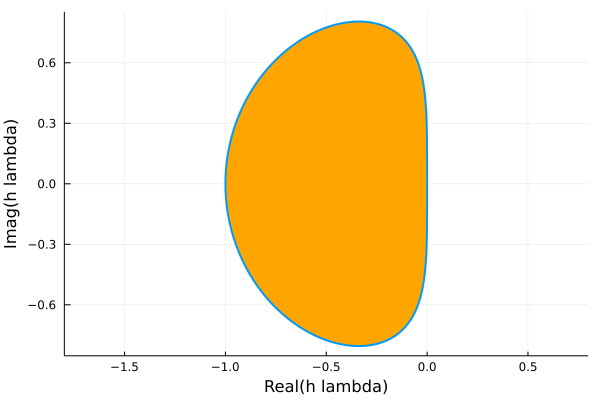

In [8]:
Zxn = lambdify(sol[zx])
Zyn = lambdify(sol[zy])
plot( Zxn, Zyn, 0, 2π,
    xlabel="Real(h lambda)", ylabel="Imag(h lambda)",
    line=2,
    fill=(0, :orange),
    legend=false,
    aspect_ratio=:equal)

## Test problem #1
$$ \dot x = \begin{bmatrix} 0 & 1 \\ -1 & 0 \end{bmatrix}x $$

In [9]:
abs.( solve( ex2 |> subs(λ=>1im, h => 0.1 ), σ ) )

2-element Vector{Sym}:
 0.0499987246617530
   1.00002550741555

I can play around with the size of $h$ and see that only for $h \to 0$ will the second value go to 1.  So there is no chance of making this work for $\lambda = \pm 1j$.

## Test problem #2
$$ \dot x = \begin{bmatrix} 0 & 1 & 0 \\ 0 & 0 & 1 \\ -23 & -304 & -732 \end{bmatrix}x $$

In [10]:
using LinearAlgebra, Printf
λ2 = eigvals( [0 1 0;
        0 0 1; 
        -23 -304 -732] )

3-element Vector{Float64}:
 -731.5845065625867
   -0.31600607909323586
   -0.09948735832003104

In [11]:
abs.( solve( ex2 |> subs(λ=>λ2[1], h => 0.001 ), σ ) )

2-element Vector{Sym}:
 0.655452594111205
 0.558075834267325

We can try to visualize this

In [12]:
sol_σ = solve( ex2, σ )

2-element Vector{Sym}:
 3*h*lambda/4 - sqrt(9*h^2*lambda^2 + 4*h*lambda + 4)/4 + 1/2
 3*h*lambda/4 + sqrt(9*h^2*lambda^2 + 4*h*lambda + 4)/4 + 1/2

In [13]:
Σ(h, λ, j) = abs( lambdify(sol_σ[j])(h,λ) )

Σ (generic function with 1 method)

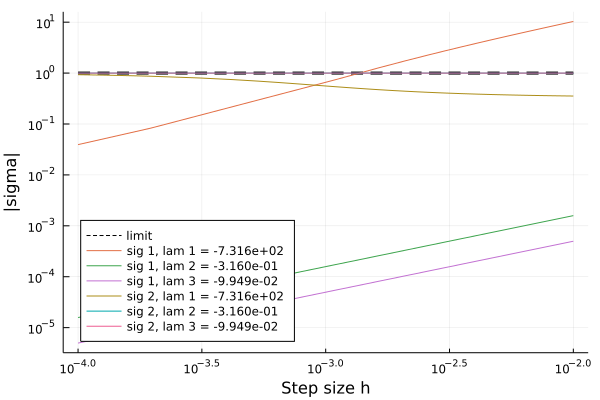

In [14]:
plt = plot( σ -> 1, 1e-4, 1e-2, lw=3, linestyle=:dash, color=:black, label="limit",
    xscale=:log10, yscale=:log10, legend=:bottomleft,
    xlabel="Step size h", ylabel="|sigma|" )
for j = 1:2
    for i = 1:3
        plot!(plt, h->Σ.(h, λ2[i], j ), 1e-4, 1e-2, label=@sprintf("sig %d, lam %d = %.3e", j, i, λ2[i]) )
    end
end
plt

In [15]:
import Roots

In [16]:
function  resid(h,λr)
    t = maximum( [ maximum( abs.( lambdify(sol_σ)(h,λ) ) ) for λ in λr ] )
    return 1 - t
end

resid (generic function with 1 method)

In [17]:
hstar = Roots.fzero( h->resid(h, λ2), 1e-2)

0.001366896087915512

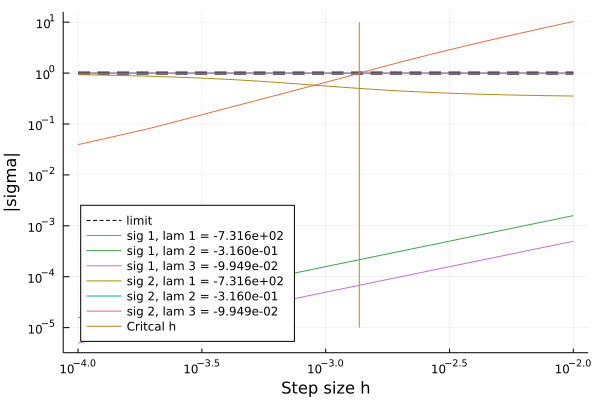

In [18]:
plot!( [hstar, hstar], [1e-5, 10], label="Critcal h" )

# Implicit Midpoint Example
$$ x_{n+1} = x_n + h f\left( t_n + \frac{h}{2},\, \frac{x_n + x_{n+1}}{2} \right) $$

In [19]:
ex1 = - X(n+1) + X(n) + h*λ*( (X(n) + X(n+1))//2 ) 

         /     n            n + 1    \                              
         |sigma *x_0   sigma     *x_0|        n            n + 1    
h*lambda*|---------- + --------------| + sigma *x_0 - sigma     *x_0
         \    2              2       /                              

In [20]:
ex2 = ex1/σ^(n)*2/x0 |> expand |> simplify

h*lambda*sigma + h*lambda - 2*sigma + 2

In [21]:
ex3 = ex2 |> subs(h=>1, λ=>zx + zy*1im, σ=> cos(θ) + 1im*sin(θ) ) |> expand |> simplify

I*z_x*sin(theta) + z_x*cos(theta) + z_x - z_y*sin(theta) + I*z_y*cos(theta) + 
I*z_y - 2*I*sin(theta) - 2*cos(theta) + 2

In [22]:
solve( [ real(ex3), imag(ex3) ], [zx, zy] )

Dict{Any, Any} with 2 entries:
  z_y => 4*sin(theta)/(sin(theta)^2 + cos(theta)^2 + 2*cos(theta) + 1)
  z_x => 2*sin(theta)^2/(sin(theta)^2 + cos(theta)^2 + 2*cos(theta) + 1) + 2*co…

Since $z_x = 0$ for all $\theta$, and $z_y$ blows up for some values, we can see that this is a vertical line at the origin.  The entire left half plane is stable.

## Example problem #2 from before

In [23]:
λ2

3-element Vector{Float64}:
 -731.5845065625867
   -0.31600607909323586
   -0.09948735832003104

In [24]:
sol_σ = solve( ex2, σ )[1]

-(h*lambda + 2) 
----------------
  h*lambda - 2  

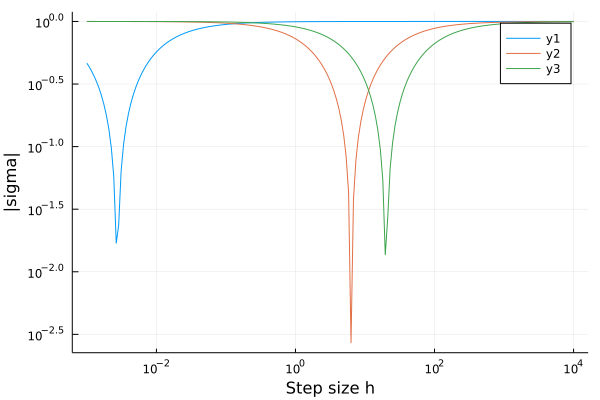

In [25]:
hr = 10 .^LinRange(-3, 4, 200)
data = [ abs.( lambdify(sol_σ)(h,λ) ) for h in hr, λ in λ2 ]
plot( hr, data, xlabel="Step size h", ylabel="|sigma|", 
    yscale=:log10, xscale=:log10 )

We can see that it is always good.